In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import upsetplot

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smt

from Bio.Seq import Seq
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import pearsonr

import plotting
from plotting import PAPER_PRESET, PAPER_FONTSIZE, annotate_pval, mimic_r_boxplot


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [3]:
from data_loading import (load_annotated_TFiso1_collection,
                          load_annotated_gencode_tfs,
                          load_valid_isoform_clones,
                          load_developmental_tissue_expression_gencode)

In [4]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [5]:
pal = {"ref": sns.color_palette("Set2")[0],
       "rewire": sns.color_palette("Set2")[2],
       "DN": sns.color_palette("Set2")[1],
       "NA": "lightgray",
       "likely": "darkgray"}

## variables

In [6]:
dn_data_f = "../data/processed/DN_cats_Joung.tsv"

In [7]:
brca_cnts_f = "../data/processed/Nathans_analysis/Breast_cancer/isoCounts.BreastCancer.txt"
brca_tx_f = "../data/processed/Nathans_analysis/Breast_cancer/transcript.BreastCancer.txt"
pam50_f = "../data/processed/Nathans_analysis/Breast_cancer/groups.PAM50.txt"
bulk_f = "../data/processed/Nathans_analysis/Breast_cancer/groups.BreastCancer_ratios.txt"

## 1. import data

In [8]:
dn_data = pd.read_table(dn_data_f)
dn_data.head()

,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,Source,Name,RefSeq Gene Name,...,match_type,joung_id,enst,seq_aa_tf1p0,TF ORF,Diffusion P-value,Diffusion difference,RNA Velocity P-value,RNA Velocity difference,orf_len
0,ZBTB18,C2H2 ZF,ZBTB18|1/2|04E08,False,True,ref,ref,Genewiz,TFORF2495,ZBTB18,...,seq_aa,TFORF2495,['ENST00000358704'],MCPKGYEDSMEFPDHSRHLLQCLSEQRHQGFLCDCTVLVGDAQFRA...,TFORF2495-ZBTB18,1.725205e-01,0.002115,0.168074,-0.004946,531.0
1,PRRX1,Homeodomain,PRRX1|2/3|09F06,False,True,ref,ref,Genewiz,TFORF1217,PRRX1,...,seq_aa,TFORF1217,['ENST00000239461'],MTSSYGHVLERQPALGGRLDSPGNLDTLQAKKNFSVSHLLDLEEAG...,TFORF1217-PRRX1,3.652862e-01,0.000400,0.000021,-0.009730,245.0
2,POU2F1,Homeodomain; POU,POU2F1|2/2|04D01,False,False,ref,ref,Broad GPP,TFORF3019,POU2F1,...,seq_aa,TFORF3019,['ENST00000541643'],MNNPSETSKPSMESGDGNTGTQTNGLDFQKQPVPVGGAISTAQAQA...,TFORF3019-POU2F1,4.562077e-01,0.001600,0.023410,-0.012525,743.0
3,ATF3,bZIP,ATF3|1/2|08B04,False,True,ref,ref,Genewiz,TFORF0801,ATF3,...,seq_aa,TFORF0801,"['ENST00000341491', 'ENST00000366987']",MMLQHPGQVSASEVSASAIVPCLSPPGSLVFEDFANLTPFVKEELR...,TFORF0801-ATF3,1.179785e-03,0.002153,0.000246,-0.004118,181.0
4,GRHL3,Grainyhead,GRHL3|3/7|08G09,False,True,ref,ref,Genewiz,TFORF2165,GRHL3,...,seq_aa,TFORF2165,['ENST00000361548'],MSNELDFRSVRLLKNDPVNLQKFSYTSEDEAWKTYLENPLTAATKA...,TFORF2165-GRHL3,2.270000e-07,-0.030514,0.000001,-0.039517,602.0


In [9]:
skiprows=list(range(96320, 96387))+list(range(99680,99687))
brca = pd.read_table(brca_tx_f, sep="\t", skiprows=skiprows)
brca.shape

(99774, 1223)

In [10]:
pam50_samps = pd.read_table(pam50_f, header=None)
pam50_samps.columns = ["file", "samp_type_id", "samp_type"]
pam50_samps["tcga_id"] = pam50_samps["file"].str.split(".", expand=True)[0]
pam50_samps.samp_type.value_counts()

Luminal A        232
Luminal B        125
controls         119
Basal-like       101
HER2-enriched     58
Normal-like        8
Name: samp_type, dtype: int64

In [11]:
bulk_samps = pd.read_table(bulk_f, header=None)
bulk_samps.columns = ["file", "samp_type_id", "samp_type"]
bulk_samps["tcga_id"] = bulk_samps["file"].str.split(".", expand=True)[0]
bulk_samps.samp_type.value_counts()

BC          1104
controls     119
Name: samp_type, dtype: int64

## 2. map sample types

In [12]:
brca_samps = list(bulk_samps[bulk_samps["samp_type"] != "controls"]["tcga_id"])
print("# breast cancer samples: %s" % len(brca_samps))


# same ctrls in both
ctrl_samps = list(pam50_samps[pam50_samps["samp_type"] == "controls"]["tcga_id"])
print("# control samples: %s" % len(ctrl_samps))

luma_samps = list(pam50_samps[pam50_samps["samp_type"] == "Luminal A"]["tcga_id"])
print("# Luminal A samples: %s" % len(luma_samps))

lumb_samps = list(pam50_samps[pam50_samps["samp_type"] == "Luminal B"]["tcga_id"])
print("# Luminal B samples: %s" % len(lumb_samps))

tn_samps = list(pam50_samps[pam50_samps["samp_type"] == "Basal-like"]["tcga_id"])
print("# Basal-like samples: %s" % len(tn_samps))

her2_samps = list(pam50_samps[pam50_samps["samp_type"] == "HER2-enriched"]["tcga_id"])
print("# HER2-enriched samples: %s" % len(her2_samps))

norm_samps = list(pam50_samps[pam50_samps["samp_type"] == "Normal-like"]["tcga_id"])
print("# Normal-like samples: %s" % len(norm_samps))

# breast cancer samples: 1104
# control samples: 119
# Luminal A samples: 232
# Luminal B samples: 125
# Basal-like samples: 101
# HER2-enriched samples: 58
# Normal-like samples: 8


In [13]:
# one brca samp is weirdly missing, remove
brca_samps = [x for x in brca_samps if x in brca.columns]
len(brca_samps)

1103

In [14]:
## patient is the 3rd value in the barcode
## source: https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/
bulk_samps["patient_id"] = bulk_samps["tcga_id"].str.split("-", expand=True)[2]
pam50_samps["patient_id"] = pam50_samps["tcga_id"].str.split("-", expand=True)[2]

In [15]:
tcga_samps = bulk_samps.merge(pam50_samps, on=["tcga_id", "patient_id"], how="outer",
                              suffixes=("_brca", "_pam50"))
print(len(tcga_samps))

1223


In [16]:
tcga_ctrls = tcga_samps[(tcga_samps["samp_type_brca"] == "controls") | (tcga_samps["samp_type_pam50"] == "controls")]
len(tcga_ctrls)

119

In [17]:
tcga_tumors = tcga_samps[(tcga_samps["samp_type_brca"] != "controls") | (tcga_samps["samp_type_pam50"] != "controls")]
len(tcga_tumors)

1104

In [18]:
tcga_paired = tcga_ctrls.merge(tcga_tumors, on=["patient_id"], suffixes=("_ctrl", "_tumor"))
print(len(tcga_paired))

123


## 3. aggregate TF iso expression across transcripts

In [19]:
tfs = load_annotated_TFiso1_collection()

reading from cache


In [20]:
tf_id_map = pd.DataFrame()
gene_names = []
iso_ids = []
clone_accs = []
enst_ids = []

for tf in tfs:
    db = tfs[tf]
    for iso in db.isoforms:
        enst_id = iso.ensembl_transcript_ids
        try:
            clone_acc = iso.clone_acc
        except:
            clone_acc = "none"
        
        if enst_id is None:
            gene_names.append(tf)
            iso_ids.append(iso.name)
            clone_accs.append(clone_acc)
            enst_ids.append("none")
        else:
            for enst_id in iso.ensembl_transcript_ids:
                gene_names.append(tf)
                iso_ids.append(iso.name)
                clone_accs.append(clone_acc)
                enst_ids.append(enst_id)

tf_id_map["gene_name"] = gene_names
tf_id_map["iso_id"] = iso_ids
tf_id_map["clone_acc"] = clone_accs
tf_id_map["enst_id"] = enst_ids
print(len(tf_id_map))
tf_id_map.sample(5)

1665


,gene_name,iso_id,clone_acc,enst_id
1082,MEIS2,MEIS2-204,none,ENST00000397624
24,ZNF691,ZNF691-2,ZNF691|2/2|05G02,ENST00000630961
573,HOXA1,HOXA1-1,HOXA1|1/2|04F04,ENST00000643460
321,PRDM5,PRDM5-3,PRDM5|3/3|02A01,ENST00000394435
800,OVOL1,OVOL1-1,OVOL1|1/2|11D06,ENST00000335987


In [21]:
def merge_id(row):
    if row.enst_id == "none":
        return row.clone_acc
    else:
        return row.enst_id
    
tf_id_map["merge_id"] = tf_id_map.apply(merge_id, axis=1)
tf_id_map.sample(5)

,gene_name,iso_id,clone_acc,enst_id,merge_id
533,DLX6,DLX6-202,none,ENST00000518156,ENST00000518156
1171,ZNF19,ZNF19-210,none,ENST00000567225,ENST00000567225
1325,TCF4,TCF4-205,none,ENST00000568673,ENST00000568673
1506,ZNF772,ZNF772-203,none,ENST00000425074,ENST00000425074
1657,ZFY,ZFY-1,ZFY|1/2|06H10,none,ZFY|1/2|06H10


In [22]:
dd = tf_id_map[["iso_id", "gene_name"]].drop_duplicates()
print(len(dd))
gene_dict = {row.iso_id : row.gene_name for i, row in dd.iterrows()}

1376


In [23]:
brca_cols = [x for x in brca.columns if x != "UID"]
len(brca_cols)

1222

In [24]:
brca = brca.merge(tf_id_map, left_on="UID", right_on="merge_id")
len(brca)

1664

In [25]:
brca_isos = brca.groupby("iso_id")[brca_cols].agg("sum").reset_index()
len(brca_isos)

1375

In [26]:
brca_isos.head()

,iso_id,TCGA-AC-A3QP-01A-11R-A22U-07,TCGA-BH-A0HB-01A-11R-A056-07,TCGA-B6-A0RM-01A-11R-A084-07,TCGA-A2-A25F-01A-11R-A169-07,TCGA-AN-A03X-01A-21R-A00Z-07,TCGA-A2-A25D-01A-12R-A16F-07,TCGA-D8-A3Z6-01A-11R-A239-07,TCGA-BH-A0W5-01A-11R-A109-07,TCGA-AO-A03V-01A-11R-A115-07,...,TCGA-AR-A24N-01A-11R-A169-07,TCGA-B6-A0WT-01A-11R-A109-07,TCGA-A7-A3IY-01A-21R-A21T-07,TCGA-AR-A5QM-01A-11R-A27Q-07,TCGA-BH-A1FU-11A-23R-A14D-07,TCGA-BH-A0DH-11A-31R-A089-07,TCGA-E2-A10E-01A-21R-A10J-07,TCGA-E9-A1ND-11A-43R-A144-07,TCGA-A8-A09K-01A-11R-A00Z-07,TCGA-A8-A0AD-01A-11R-A056-07
0,AEBP2-2,0.00000,0.000000,0.884969,1.814470,0.887561,0.378890,1.651040,1.77029,0.000000,...,0.476599,0.00000,0.077865,0.000000,3.97740,0.00000,0.034021,0.00000,3.835620,0.00000
1,AEBP2-201,1.26676,2.019730,3.588720,4.549070,1.473740,1.507640,2.665370,2.03800,4.031440,...,2.594580,3.15962,2.871930,2.583600,4.03035,1.48186,3.609680,1.49766,2.255110,3.88637
2,AEBP2-202,2.69345,3.795300,4.965690,8.475100,4.661620,3.247560,3.662790,5.34347,6.067000,...,5.662630,6.32062,6.833820,4.634820,4.43878,2.51768,8.357350,3.30786,1.655240,9.15609
3,AEBP2-204,0.00000,0.503578,0.031885,0.011918,0.000000,0.016137,0.000000,0.00000,0.035119,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.17198,0.104846,0.00000
4,AEBP2-207,0.00000,0.946881,3.609280,13.282700,4.174560,0.431527,0.344149,2.18314,3.986220,...,5.934700,7.72157,0.000000,0.798722,11.54100,4.04379,7.513020,0.00000,6.482200,6.27588


## 4. calculate isoform ratios

In [27]:
# calculate isoform ratios, set anything w gene-level exp <= 1 to nan
brca_genes = pd.Series(index=brca_isos.iso_id, data=brca_isos.iso_id.map(gene_dict).values)

brca_idx = brca_isos.set_index("iso_id", inplace=False)
brca_idx = brca_idx[brca_cols]
brca_gene_sum = brca_idx.groupby(brca_genes).transform('sum')

f_brca = brca_idx/brca_gene_sum
f_brca_nan = f_brca * (brca_gene_sum >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])

## 5. calculate median expression + ratio in each PAM50 type

In [28]:
tcga_paired_ctrls = list(tcga_paired["tcga_id_ctrl"].unique())
tcga_paired_tumors = list(tcga_paired["tcga_id_tumor"].unique())

In [29]:
brca_isos["med_brca_tpm"] = brca_isos[brca_samps].median(axis=1)
brca_isos["med_ctrl_tpm"] = brca_isos[ctrl_samps].median(axis=1)
brca_isos["med_luma_tpm"] = brca_isos[luma_samps].median(axis=1)
brca_isos["med_lumb_tpm"] = brca_isos[lumb_samps].median(axis=1)
brca_isos["med_tn_tpm"] = brca_isos[tn_samps].median(axis=1)
brca_isos["med_her2_tpm"] = brca_isos[her2_samps].median(axis=1)
brca_isos["med_norm_tpm"] = brca_isos[norm_samps].median(axis=1)
brca_isos["med_paired-brca_tpm"] = brca_isos[tcga_paired_tumors].median(axis=1)
brca_isos["med_paired-ctrls_tpm"] = brca_isos[tcga_paired_ctrls].median(axis=1)

In [30]:
f_brca_nan["med_brca_rationan"] = f_brca_nan[brca_samps].median(axis=1)
f_brca_nan["med_ctrl_rationan"] = f_brca_nan[ctrl_samps].median(axis=1)
f_brca_nan["med_luma_rationan"] = f_brca_nan[luma_samps].median(axis=1)
f_brca_nan["med_lumb_rationan"] = f_brca_nan[lumb_samps].median(axis=1)
f_brca_nan["med_tn_rationan"] = f_brca_nan[tn_samps].median(axis=1)
f_brca_nan["med_her2_rationan"] = f_brca_nan[her2_samps].median(axis=1)
f_brca_nan["med_norm_rationan"] = f_brca_nan[norm_samps].median(axis=1)
f_brca_nan["med_paired-brca_rationan"] = f_brca_nan[tcga_paired_tumors].median(axis=1)
f_brca_nan["med_paired-ctrls_rationan"] = f_brca_nan[tcga_paired_ctrls].median(axis=1)

In [31]:
f_brca["med_brca_ratio"] = f_brca[brca_samps].median(axis=1)
f_brca["med_ctrl_ratio"] = f_brca[ctrl_samps].median(axis=1)
f_brca["med_luma_ratio"] = f_brca[luma_samps].median(axis=1)
f_brca["med_lumb_ratio"] = f_brca[lumb_samps].median(axis=1)
f_brca["med_tn_ratio"] = f_brca[tn_samps].median(axis=1)
f_brca["med_her2_ratio"] = f_brca[her2_samps].median(axis=1)
f_brca["med_norm_ratio"] = f_brca[norm_samps].median(axis=1)
f_brca["med_paired-brca_ratio"] = f_brca[tcga_paired_tumors].median(axis=1)
f_brca["med_paired-ctrls_ratio"] = f_brca[tcga_paired_ctrls].median(axis=1)

## 7. calculate expression/ratio change per isoform across paired samps

In [32]:
paired_ctrl_samps = list(tcga_paired["tcga_id_ctrl"])
print(len(paired_ctrl_samps))
paired_tumor_samps = list(tcga_paired["tcga_id_tumor"])
print(len(paired_tumor_samps))

123
123


In [33]:
## calculate p-value using wilcoxon
def paired_pval(row, ctrl_cols, tumor_cols):
    x = row[ctrl_cols]
    x = [x for x in x if not pd.isnull(x)]
    y = row[tumor_cols]
    y = [y for y in y if not pd.isnull(y)]
    
    try:
        stat, p = wilcoxon(x, y)
        return p
    except:
        return np.nan
    
## calculate p-value using wilcoxon
def paired_stat(row, ctrl_cols, tumor_cols):
    x = row[ctrl_cols]
    y = row[tumor_cols]
    
    try:
        stat, p = wilcoxon(x, y)
        return stat
    except:
        return np.nan

f_brca["wilcox_pval"] = f_brca.apply(paired_pval, ctrl_cols=paired_ctrl_samps, tumor_cols=paired_tumor_samps, axis=1)
f_brca["wilcox_stat"] = f_brca.apply(paired_stat, ctrl_cols=paired_ctrl_samps, tumor_cols=paired_tumor_samps, axis=1)
print(len(f_brca))

f_brca_filt = f_brca[~pd.isnull(f_brca["wilcox_pval"])]
print(len(f_brca_filt))

f_brca_filt["wilcox_padj"] = smt.multipletests(list(f_brca_filt["wilcox_pval"]), alpha=0.05, method="fdr_bh")[1]

f_brca_nan["wilcox_pval"] = f_brca_nan.apply(paired_pval, ctrl_cols=paired_ctrl_samps, tumor_cols=paired_tumor_samps, axis=1)
f_brca_nan["wilcox_stat"] = f_brca_nan.apply(paired_stat, ctrl_cols=paired_ctrl_samps, tumor_cols=paired_tumor_samps, axis=1)
print(len(f_brca_nan))

f_brca_nan_filt = f_brca_nan[~pd.isnull(f_brca_nan["wilcox_pval"])]
print(len(f_brca_nan_filt))

f_brca_nan_filt["wilcox_padj"] = smt.multipletests(list(f_brca_nan_filt["wilcox_pval"]), alpha=0.05, method="fdr_bh")[1]

1375
1204
1375
715


In [34]:
for i, row in tcga_paired.iterrows():
    f_brca_filt["paired-diff_%s_ratio" % (i+1)] = f_brca_filt[row.tcga_id_tumor]-f_brca_filt[row.tcga_id_ctrl]
    f_brca_nan_filt["paired-diff_%s_rationan" % (i+1)] = f_brca_nan_filt[row.tcga_id_tumor].fillna(0)-f_brca_nan[row.tcga_id_ctrl].fillna(0)

In [35]:
paired_ratio_cols = [x for x in f_brca_filt.columns if "paired-diff_" in x]
paired_rationan_cols = [x for x in f_brca_nan_filt.columns if "paired-diff_" in x]

In [36]:
f_brca_filt["med_paired-diff_ratio"] = f_brca_filt[paired_ratio_cols].median(axis=1)
f_brca_nan_filt["med_paired-diff_rationan"] = f_brca_nan_filt[paired_rationan_cols].median(axis=1)

## 6. merge median expression w/ DN cats

In [37]:
f_brca_filt = f_brca_filt.merge(tf_id_map, on="iso_id")
f_brca_nan_filt = f_brca_nan_filt.merge(tf_id_map, on="iso_id")

In [38]:
f_brca_nan_med_cols = ["clone_acc"] + [x for x in f_brca_nan_filt.columns if "med_" in x] + [x for x in f_brca_nan_filt.columns if "wilcox" in x]

In [39]:
f_brca_med_cols = ["clone_acc"] + [x for x in f_brca_filt.columns if "med_" in x] + [x for x in f_brca_filt.columns if "wilcox" in x]

In [40]:
dn_data_exp = dn_data.merge(f_brca_nan_filt[f_brca_nan_med_cols], left_on="tf1p0_id", right_on="clone_acc")
dn_data_exp = dn_data_exp.merge(f_brca_filt[f_brca_med_cols], left_on="tf1p0_id", right_on="clone_acc", 
                                suffixes=("_nan", "")).drop_duplicates()
print(len(dn_data_exp))

334


In [41]:
dn_data_exp["neglog_padj"] = -np.log10(dn_data_exp["wilcox_padj"])
dn_data_exp["neglog_padj_nan"] = -np.log10(dn_data_exp["wilcox_padj_nan"])

## 7. plots

In [42]:
len(dn_data_exp[(dn_data_exp["wilcox_padj"] < 0.05) & (dn_data_exp["dn_cat"].isin(["ref", "rewire", "DN"]))])

87

In [43]:
len(dn_data_exp[(dn_data_exp["wilcox_padj"] < 0.05) & (dn_data_exp["dn_cat"] == "ref")])

48

In [44]:
len(dn_data_exp[(dn_data_exp["wilcox_padj"] < 0.05) & (dn_data_exp["dn_cat"] == "DN")])

30

In [45]:
len(dn_data_exp[(dn_data_exp["wilcox_padj"] < 0.05) & (dn_data_exp["dn_cat"] == "rewire")])

9

In [46]:
len(dn_data_exp[dn_data_exp["dn_cat"].isin(["ref", "rewire", "DN"])])

212

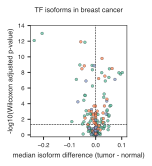

In [47]:
fig = plt.figure(figsize=(2, 2.2))

ax = sns.scatterplot(data=dn_data_exp[dn_data_exp["dn_cat"].isin(["ref", "rewire", "DN"])], 
                     x="med_paired-diff_ratio", y="neglog_padj", 
                     hue="dn_cat", palette=pal, linewidth=0.25, edgecolor="black", alpha=0.8, zorder=10,
                     **{"s": 8})

ax.set_xlabel("median isoform difference (tumor - normal)")
ax.set_ylabel("-log10(Wilcoxon adjusted p-value)")
ax.set_title("TF isoforms in breast cancer\n")

ax.set_xlim((-0.25, 0.12))
ax.set_ylim((-0.25, 14))
ax.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=0.5)
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)

ax.get_legend().remove()

fig.savefig("../figures/BRCA_Volcano.pdf", dpi="figure", bbox_inches="tight")

In [48]:
dn_data_exp[dn_data_exp["gene_name"]=="KLF7"][["tf1p0_id", "dn_cat", "med_paired-diff_ratio", "neglog_padj"]]

,tf1p0_id,dn_cat,med_paired-diff_ratio,neglog_padj
41,KLF7|1/8|01E06,ref,-0.016988,0.091971
334,KLF7|3/8|10B10,rewire,-0.068308,4.239926
335,KLF7|4/8|10E10,DN,0.029539,2.102873
336,KLF7|5/8|11H02,DN,0.002130,1.271087
337,KLF7|6/8|01D06,NaN,0.000000,0.522558
338,KLF7|7/8|10H08,DN,0.000000,0.159276
339,KLF7|8/8|10D09,NaN,0.000000,0.856424


In [50]:
dn_data_exp[dn_data_exp["dn_cat"].isin(["ref", "rewire", "DN"])][["gene_name", "family", "tf1p0_id",
                                                                  "dn_cat", "med_paired-diff_ratio", 
                                                                  "neglog_padj"]].sort_values(by="neglog_padj", 
                                                                                              ascending=False).head(20)

,gene_name,family,tf1p0_id,dn_cat,med_paired-diff_ratio,neglog_padj
9,NFIA,SMAD,NFIA|2/5|02G09,ref,-0.205456,12.997297
42,TFDP2,E2F,TFDP2|1/4|03C12,ref,-0.235812,12.091513
805,ZBTB25,C2H2 ZF,ZBTB25|4/5|04D09,DN,-0.057185,11.928042
34,STAT1,STAT,STAT1|1/7|01B05,ref,-0.041268,11.861685
392,ZNF451,C2H2 ZF,ZNF451|8/8|06F02,DN,0.024408,9.791616
298,PKNOX1,Homeodomain,PKNOX1|1/4|11H11,ref,-0.060639,8.961888
25,ELK4,Ets,ELK4|1/2|07H08,ref,-0.013613,8.901470
385,NFYA,CBF/NF-Y,NFYA|2/3|07G01,rewire,-0.005593,8.858212
940,PATZ1,C2H2 ZF; AT hook,PATZ1|3/4|02A04,DN,-0.043469,8.847031
936,PKNOX1,Homeodomain,PKNOX1|2/4|06H05,DN,0.063234,8.500940


In [51]:
brca_isos = brca_isos.merge(tf_id_map[["iso_id", "gene_name"]], on="iso_id").drop_duplicates()
len(brca_isos)

1375

In [52]:
brca_isos_paired = brca_isos[["gene_name", "iso_id"] + tcga_paired_ctrls + tcga_paired_tumors]
new_ctrl_cols = ["normal - %s" % (i+1) for i, x in enumerate(tcga_paired_ctrls)]
new_tumor_cols = ["tumor - %s" % (i+1) for i, x in enumerate(tcga_paired_tumors)]
brca_isos_paired.columns = ["gene_name", "iso_id"] + new_ctrl_cols + new_tumor_cols

In [53]:
def brca_expression_plot(gene_name, figsize, ylim, df, cols, fig_suffix, ctrls_line, tumor_line):
    df_sub = df[df["gene_name"] == gene_name]
    df_sub.set_index("iso_id", inplace=True)
    df_sub = df_sub[cols].drop_duplicates()
    #print(df_sub.head())
    n_isos = len(df_sub)
    palette = sns.color_palette("husl", as_cmap=False, n_colors=n_isos)
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (df_sub
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    (df_sub.div(df_sub.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_yscale("symlog")
    axes[0].set_ylabel('tpm')
    #axes[0].set_ylim(ylim)
    axes[1].set_ylabel('percent')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0))
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    
    # add medians
    axes[1].plot(ctrls_line[0], ctrls_line[1], color="black", linewidth=0.5, linestyle="dashed")
    axes[1].plot(tumor_line[0], tumor_line[1], color="black", linewidth=0.5, linestyle="dashed")
    
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../figures/brca_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

In [54]:
dn_data_exp[dn_data_exp["gene_name"] == "PKNOX1"][["gene_name", "tf1p0_id", "dn_cat", "med_paired-brca_ratio",
                                                   "med_paired-ctrls_ratio", "med_paired-diff_ratio"]]

,gene_name,tf1p0_id,dn_cat,med_paired-brca_ratio,med_paired-ctrls_ratio,med_paired-diff_ratio
298,PKNOX1,PKNOX1|1/4|11H11,ref,0.550168,0.620462,-0.060639
936,PKNOX1,PKNOX1|2/4|06H05,DN,0.418081,0.340229,0.063234
937,PKNOX1,PKNOX1|3/4|06H03,DN,0.029985,0.036398,-0.009123
938,PKNOX1,PKNOX1|4/4|06G03,DN,0.000000,0.000000,0.000000


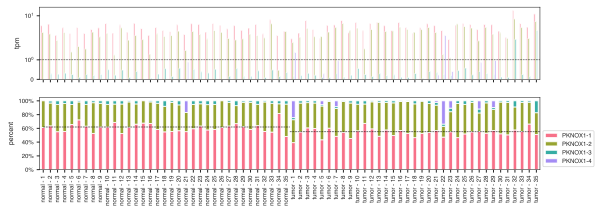

In [55]:
cols = new_ctrl_cols[0:35] + new_tumor_cols[0:35]
brca_expression_plot("PKNOX1", (9, 3), (0, 6), brca_isos_paired, cols, "paired",
                     ([0, 34.5], [0.62, 0.62]), ([34.5, 70], [0.55, 0.55]))

In [56]:
f_brca_paired = f_brca_filt[["gene_name", "iso_id"] + tcga_paired_ctrls + tcga_paired_tumors]
new_ctrl_cols = ["normal - %s" % (i+1) for i, x in enumerate(tcga_paired_ctrls)]
new_tumor_cols = ["tumor - %s" % (i+1) for i, x in enumerate(tcga_paired_tumors)]
f_brca_paired.columns = ["gene_name", "iso_id"] + new_ctrl_cols + new_tumor_cols

In [57]:
f_brca_paired_melt = pd.melt(f_brca_paired, id_vars=["gene_name", "iso_id"])
f_brca_paired_melt["samp"] = f_brca_paired_melt["variable"].str.split(" ", expand=True)[0]

In [58]:
dn_data_exp = dn_data_exp.merge(tf_id_map[["gene_name", "clone_acc", "iso_id", "merge_id"]], 
                                left_on=["gene_name", "tf1p0_id"],
                                right_on=["gene_name", "clone_acc"]).drop_duplicates()
print(len(dn_data_exp))
dn_data_exp[dn_data_exp["gene_name"]=="PKNOX1"]

431


,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,Source,Name,RefSeq Gene Name,...,med_paired-ctrls_ratio,med_paired-diff_ratio,wilcox_pval,wilcox_stat,wilcox_padj,neglog_padj,neglog_padj_nan,clone_acc_y,iso_id,merge_id
164,PKNOX1,Homeodomain,PKNOX1|1/4|11H11,False,True,ref,ref,Broad GPP,TFORF3468,PKNOX1,...,0.620462,-0.060639,2.629562e-11,1172.0,1.091721e-09,8.961888,9.106022,PKNOX1|1/4|11H11,PKNOX1-1,ENST00000291547
426,PKNOX1,Homeodomain,PKNOX1|2/4|06H05,True,False,DN,alt,NaN,NaN,NaN,...,0.340229,0.063234,9.696959e-11,1249.0,3.155443e-09,8.500940,8.650420,PKNOX1|2/4|06H05,PKNOX1-2,PKNOX1|2/4|06H05
427,PKNOX1,Homeodomain,PKNOX1|3/4|06H03,False,False,DN,alt,Genewiz,TFORF1274,PKNOX1,...,0.036398,-0.009123,5.392954e-04,2442.0,2.835422e-03,2.547382,2.578220,PKNOX1|3/4|06H03,PKNOX1-3,ENST00000432907
428,PKNOX1,Homeodomain,PKNOX1|4/4|06G03,True,False,DN,alt,NaN,NaN,NaN,...,0.000000,0.000000,5.642097e-01,165.0,7.039466e-01,0.152460,0.151825,PKNOX1|4/4|06G03,PKNOX1-4,PKNOX1|4/4|06G03


PKNOX1-1
PKNOX1-2
PKNOX1-3
PKNOX1-4


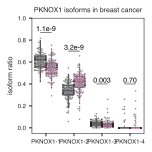

In [59]:
tmp = f_brca_paired_melt[f_brca_paired_melt["gene_name"] == "PKNOX1"]

fig = plt.figure(figsize=(2, 2))

ax = sns.boxplot(data=tmp, x="iso_id", y="value", hue="samp", fliersize=0,
                 palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]})
mimic_r_boxplot(ax)

sns.swarmplot(data=tmp, x="iso_id", y="value", hue="samp",
              palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]}, ax=ax,
              size=1, edgecolor="black", linewidth=0.5, alpha=0.5, split=True)

# annotate w p-vals
ys = [0.87, 0.7, 0.4, 0.4]
for i, iso in enumerate(tmp.iso_id.unique()):
    print(iso)
    padj = dn_data_exp[dn_data_exp["iso_id"]==iso]["wilcox_padj"].iloc[0]
    
    annotate_pval(ax, i-0.2, i+0.2, ys[i], 0, ys[i], padj, PAPER_FONTSIZE)

ax.set_xlabel("")
ax.set_ylabel("isoform ratio")
ax.set_title("PKNOX1 isoforms in breast cancer")
ax.get_legend().remove()
ax.set_ylim((-0.05, 1))

fig.savefig("../figures/BRCA_PKNOX1_boxplot.pdf", dpi="figure", bbox_inches="tight")

## read in TCGA PanCan data

In [60]:
pancan = pd.read_table("../data/external/PanCan_PKNOX1_w_header.txt")
pancan.head()

,event_id,event_type,event_chr,event_coordinates,alt_region_coordinates,gene_name,TCGA-ED-A459-01A-11R-A266-07.31c9c8be-6cde-4db6-b9fd-6173b41bedc8.aligned,TCGA-DD-A4NA-01A-11R-A266-07.59b320d5-a277-4723-b9f0-d1e7fe2a20af.aligned,TCGA-DD-A4ND-01A-11R-A266-07.b3d02a68-fde3-42cd-8ca2-7e3565f85632.aligned,TCGA-DD-A4NB-01A-12R-A266-07.173a2cc4-0d27-4a27-857f-97a0e53fa8d1.aligned,...,TCGA-EJ-5516-01A-01R-1580-07.6320daab-3fdb-45d2-bbc8-bbba33e4af37.aligned,TCGA-HC-7212-01A-11R-2118-07.23e9edc6-a5ab-4dca-9243-a40e69d65615.aligned,TCGA-G9-6363-01A-21R-1789-07.766eb893-3bc9-4a17-9b66-7eed2b1c01c3.aligned,TCGA-G9-6348-01A-11R-1789-07.f1647dd0-3eda-473f-9902-12d0817ee165.aligned,TCGA-EJ-5506-01A-01R-1580-07.e67b3b01-fdd5-49de-8829-84298c131a5f.aligned,TCGA-G9-6356-01A-11R-1789-07.9584ae14-c30b-421b-8975-b5b1bb94a465.aligned,TCGA-ND-A4WF-01A-11R-A28V-07.056147b5-8802-4981-9774-5fce244c4db3.aligned,TCGA-G9-6378-01A-11R-1789-07.02334a5d-c3a2-4ea6-8e4e-d603a8fbc43c.aligned,TCGA-N8-A4PM-01A-11R-A28V-07.3222c877-1ff5-4b73-a76b-9ce3130b9b2b.aligned,TCGA-CH-5767-01A-11R-1789-07.07f49527-0833-481f-b172-cb67601f8b03.aligned
0,alt_3prime_164349,A3,21,44433177:44433348:44437020:44437117:44437017:4...,44437017:44437020,ENSG00000160199.10,0.0,0.0,0.0,0.083333,...,0.0,0.025641,NaN,0.137931,0.083333,0.0,0.090909,0.0,0.095238,0.0


In [62]:
cols = ["event_id", "event_type", "event_chr", "event_coordinates", "alt_region_coordinates", "gene_name"]
samp_cols = [x.split(".")[0] for x in pancan.columns if x.startswith("TCGA")]
new_cols = cols + samp_cols
pancan.columns = new_cols
pancan.head()

,event_id,event_type,event_chr,event_coordinates,alt_region_coordinates,gene_name,TCGA-ED-A459-01A-11R-A266-07,TCGA-DD-A4NA-01A-11R-A266-07,TCGA-DD-A4ND-01A-11R-A266-07,TCGA-DD-A4NB-01A-12R-A266-07,...,TCGA-EJ-5516-01A-01R-1580-07,TCGA-HC-7212-01A-11R-2118-07,TCGA-G9-6363-01A-21R-1789-07,TCGA-G9-6348-01A-11R-1789-07,TCGA-EJ-5506-01A-01R-1580-07,TCGA-G9-6356-01A-11R-1789-07,TCGA-ND-A4WF-01A-11R-A28V-07,TCGA-G9-6378-01A-11R-1789-07,TCGA-N8-A4PM-01A-11R-A28V-07,TCGA-CH-5767-01A-11R-1789-07
0,alt_3prime_164349,A3,21,44433177:44433348:44437020:44437117:44437017:4...,44437017:44437020,ENSG00000160199.10,0.0,0.0,0.0,0.083333,...,0.0,0.025641,NaN,0.137931,0.083333,0.0,0.090909,0.0,0.095238,0.0


In [66]:
for i, row in tcga_paired.iterrows():
    try:
        pancan["paired-diff_%s_ratio" % (i+1)] = pancan[row.tcga_id_tumor]-pancan[row.tcga_id_ctrl]
        pancan["paired-diff_%s_rationan" % (i+1)] = pancan[row.tcga_id_tumor].fillna(0)-pancan[row.tcga_id_ctrl].fillna(0)
    except KeyError:
        print("missing ctrl %s or tumor %s" % (row.tcga_id_ctrl, row.tcga_id_tumor))

missing ctrl TCGA-BH-A1FB-11A-33R-A13Q-07 or tumor TCGA-BH-A1FB-01A-11R-A13Q-07
missing ctrl TCGA-E9-A1N6-11A-32R-A144-07 or tumor TCGA-E9-A1N6-01A-11R-A144-07


In [75]:
diff_cols = [x for x in pancan.columns if "paired-diff" in x]
pancan_m = pd.melt(pancan[diff_cols])
pancan_m["type"] = pancan_m['variable'].apply(lambda row: row.split('_')[-1])
pancan_m

,variable,value,type
0,paired-diff_1_ratio,0.000000,ratio
1,paired-diff_1_rationan,0.000000,rationan
2,paired-diff_2_ratio,0.115385,ratio
3,paired-diff_2_rationan,0.115385,rationan
4,paired-diff_3_ratio,0.071429,ratio
...,...,...,...
237,paired-diff_121_rationan,0.051282,rationan
238,paired-diff_122_ratio,0.116883,ratio
239,paired-diff_122_rationan,0.116883,rationan
240,paired-diff_123_ratio,0.000000,ratio


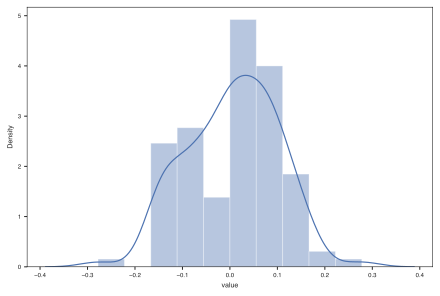

In [79]:
sns.distplot(pancan_m[pancan_m["type"]=="ratio"]["value"])

In [80]:
pancan_m[pancan_m["type"]=="ratio"]["value"].median()

0.0

In [81]:
pancan_m[pancan_m["type"]=="ratio"]["value"].mean()

0.004985760683760686